# when a chatbot needs to move from one step(state) to another, we call it state managment

In [1]:
# ! pip install langgraph langsmith

In [2]:
# ! pip install langchain langchain_groq langchain_community

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
groq_api_key = os.environ["GROQ_API_KEY"]
langsmith_api_key = os.environ["LANGSMITH_API_KEY"]


import os

os.environ["LANGCHAIN_TRACKING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LiveLanggraph"
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama3-8b-8192",
)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d116206a090>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d116206aba0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

# start building chatbot

When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. Learn more about state, reducers, and related concepts in this guide./

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END  # stategraph for state managment

# stateGraph would be changing based on some parameters
from langgraph.graph.message import add_messages  # stateGraph

# adding messages changes state of the agent, when user asks a query, llm will respond, the message will get added iver here instead and then' the state of agent will also chamhe
# basically thsese messages keep track of all those things.

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine".

In [7]:
class State(TypedDict):
    # Messages have type "List". The `add_messages` function in the annotation defines
    # how this state key should be updated.
    # (in this case, it appends messages to the list, rather  than overwriting them)
    messages: Annotated[list, add_messages]
    # we have created a variable messages and it is of type annotated and this ANnotated is saying that this islost type and I'm using fn
    # add_messages to append messages to this list
    # with every add_messages we will be chging our state

In [8]:
graph_builder = StateGraph(
    State
)  # because State knows which messages are there and what messages are basically getting appended
graph_builder  # so this graph is responsible for entire state management

# Every node needs to  take State as  a parameter, because based on these state messages, the state managment will kee on changing.

In [9]:
def chatbot(state: State):
    # after every response from chatbot, we need to update the messages variable
    return {
        "messages": llm.invoke(state["messages"])
    }  # here response is being appened to messages

    # this function is invoking the previous messages given by the user and we are returing some kind of messgae sover here.

# add this chatbot to the graph builder

In [10]:
graph_builder.add_node("chatbot", chatbot)  #

In [11]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [12]:
graph = graph_builder.compile()

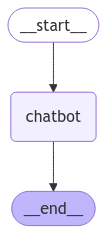

In [13]:
from IPython.display import display, Image


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# statrt and end are there by defau;t

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "q"]:
        print("Good bye")
        break

    # if user input something else
    for event in graph.stream({"messages": ("user", user_input)}):  # omput by user
        print(event.values())
        for value in event.values():
            print(f"{value['messages']=}")
            print("Assistant:", value["messages"].content)

dict_values([{'messages': AIMessage(content="It seems like you might have accidentally sent an empty message! If you meant to ask something or share something, feel free to try again, and I'll do my best to help!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 10, 'total_tokens': 48, 'completion_time': 0.031666667, 'prompt_time': 0.003578573, 'queue_time': 0.109180656, 'total_time': 0.03524524}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None}, id='run-23bc7a1b-64fd-4106-8511-0eada3c6611d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 38, 'total_tokens': 48})}])
value['messages']=AIMessage(content="It seems like you might have accidentally sent an empty message! If you meant to ask something or share something, feel free to try again, and I'll do my best to help!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens

In [16]:
user_input = "Ho ho ho!"

for event in graph.stream({"messages": ("user", user_input)}):  # omput by user
    print(f"{event.values()=}\n\n")
    for value in event.values():
        print(f"{value['messages']=}")
        print("\n\n\nAssistant:", value["messages"].content)

event.values()=dict_values([{'messages': AIMessage(content="Ho ho ho! It sounds like someone's getting into the holiday spirit!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 14, 'total_tokens': 30, 'completion_time': 0.013333333, 'prompt_time': 0.00273862, 'queue_time': 0.045689736, 'total_time': 0.016071953}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-79f8cdeb-7666-4ebd-8d01-34ee3f9a5ccd-0', usage_metadata={'input_tokens': 14, 'output_tokens': 16, 'total_tokens': 30})}])


value['messages']=AIMessage(content="Ho ho ho! It sounds like someone's getting into the holiday spirit!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 14, 'total_tokens': 30, 'completion_time': 0.013333333, 'prompt_time': 0.00273862, 'queue_time': 0.045689736, 'total_time': 0.016071953}, 'model_name': 'llama3-8b-8192', 'system_fi

Our graph can now handle two key tasks:

Each node can receive the current State as input and output an update to the state.
Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

It seems like you're trying to define a `State` class with a `messages` key that holds a list of messages, and you're annotating the list to be updated by an `add_messages` function. There is a small issue with the code. You need to close the `Annotated` function properly, and the `add_messages` function should be referenced as a callable or a function that modifies the list. Here's how you can modify the code:

```python
from typing import TypedDict, List
from typing_extensions import Annotated

def add_messages(messages: List[str], new_message: str) -> List[str]:
    """Example function to add a message to the list."""
    messages.append(new_message)
    return messages

class State(TypedDict):
    messages: Annotated[List[str], add_messages]
```

### Explanation:
1. `State` is a `TypedDict` that defines a dictionary structure.
2. The `messages` key is annotated with `Annotated[List[str], add_messages]`, indicating that the value is a list of strings (`List[str]`), and the `add_messages` function will modify it.
3. The `add_messages` function is defined to append a new message to the list and return the updated list.

If `add_messages` is meant to be used to update the state, you'll need to ensure that this function is applied when modifying the `messages` field, as it's not directly related to the data type annotation itself. Let me know if you'd like further clarification or adjustments!